In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16-cifake/REAL_Test_Features.csv
/kaggle/input/vgg16-cifake/Fake_Train_Features.csv
/kaggle/input/vgg16-cifake/Fake_Test_Features.csv
/kaggle/input/vgg16-cifake/Real_Train_Features.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from time import time
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Functions to load the data from Kaggle since we can't use Loader

In [3]:
def train_data_vgg16(sample_size=1.0):
    df_real = pd.read_csv("/kaggle/input/vgg16-cifake/Real_Train_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Train_Features.csv")
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    
    df_sample = df.sample(frac=sample_size, random_state=0)
    
    X = df_sample.drop('class', axis=1)
    y = df_sample['class']
    
    return (X, y)

def test_data_vgg16():
    df_real = pd.read_csv("/kaggle/input/vgg16-cifake/REAL_Test_Features.csv")
    df_fake = pd.read_csv("/kaggle/input/vgg16-cifake/Fake_Test_Features.csv")
    
    df = pd.concat([df_real,df_fake],axis=0).drop('Unnamed: 0', axis=1)
    
    X = df.drop('class', axis=1) 
    y = df['class']
    
    return (X, y)

In [4]:
X, y = train_data_vgg16(sample_size=1.0)

## Grid search number of estimators

In [5]:
B = np.arange(20, 520, 20)
grid = {'n_estimators': B}

time_start = time()

rf = RandomForestClassifier()
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)
rfCV.fit(X, y)

time_stop = time()

print(f"Time elapsed: {(time_stop - time_start) / 60.0:.2f} minutes")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Time elapsed: 202.75 minutes


In [6]:
rfCV.best_score_

0.8690299999999999

In [7]:
rfCV.best_params_

{'n_estimators': 440}

In [8]:
print('train score: ', rfCV.cv_results_['mean_train_score'].mean())
print('validation score: ', rfCV.cv_results_['mean_test_score'].mean())

train score:  0.9999578
validation score:  0.8655316000000001


<AxesSubplot: title={'center': 'Number of Trees vs Validation Score'}, xlabel='Trees'>

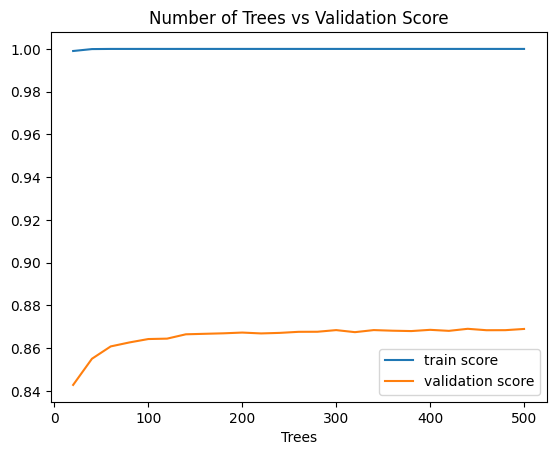

In [9]:
results = pd.DataFrame()
results['Trees'] = grid['n_estimators']
results['train score'] = rfCV.cv_results_['mean_train_score']
results['validation score'] = rfCV.cv_results_['mean_test_score']

results.plot.line(x = 'Trees', y = ['train score', 'validation score'], title='Number of Trees vs Validation Score')

In [10]:
X_test, y_test = test_data_vgg16()

## Test Score

In [11]:
rfCV.best_estimator_.score(X_test, y_test)

0.87145

## Confusion Matrix

In [12]:
confusion = pd.DataFrame()
confusion['target'] = y_test
confusion['prediction'] = rfCV.best_estimator_.predict(X_test)
confusion.head()

,target,prediction
0,Real,Real
1,Real,Real
2,Real,Fake
3,Real,Real
4,Real,Real


In [14]:
# True Positive = Real Real
# False Positive = Fake Real
# True Negative = Fake Fake
# False Negative = Real Fake
confusion.value_counts()

target  prediction
Fake    Fake          8793
Real    Real          8636
        Fake          1364
Fake    Real          1207
dtype: int64